# DocVQA EDA - Feature Extraction
Extracting geometric difficulty features to identify failure modes.

In [70]:
import os
import json
import tarfile
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # use standard tqdm, not notebook version

sns.set_style("whitegrid")

BASE_DIR = Path(r"C:\Users\Aader\Desktop\Masters\S1 P3\Final Induvidual Assignment")
DATA_DIR = BASE_DIR / "Data"

In [71]:
# Setup organized folder structure
IMAGES_DIR = DATA_DIR / "images"
OCR_DIR = DATA_DIR / "ocr"
OUTPUT_DIR = DATA_DIR / "outputs"

# Create folders if they don't exist
for folder in [IMAGES_DIR, OCR_DIR, OUTPUT_DIR]:
    folder.mkdir(exist_ok=True)

print("Folder structure:")
print(f"  {DATA_DIR}")
print(f"    /images  - extracted document images")
print(f"    /ocr     - extracted OCR json files")
print(f"    /outputs - generated plots and features")

Folder structure:
  C:\Users\Aader\Desktop\Masters\S1 P3\Final Induvidual Assignment\Data
    /images  - extracted document images
    /ocr     - extracted OCR json files
    /outputs - generated plots and features


## 1. Data Loading

In [72]:
# Extract archives into organized subfolders
archives = [
    ("spdocvqa_images.tar.gz", IMAGES_DIR),
    ("spdocvqa_ocr.tar.gz", OCR_DIR)
]

for tar_name, out_dir in archives:
    tar_path = DATA_DIR / tar_name
    
    # Check if already extracted (folder has content)
    has_content = any(out_dir.iterdir()) if out_dir.exists() else False
    
    if not has_content and tar_path.exists():
        print(f"Extracting {tar_name} -> {out_dir.name}/")
        with tarfile.open(tar_path, 'r:gz') as tar:
            tar.extractall(path=out_dir)
        print(f"  Done.")
    elif has_content:
        print(f"{out_dir.name}/ already has content, skipping extraction")
    else:
        print(f"Warning: {tar_name} not found")

Extracting spdocvqa_images.tar.gz -> images/
  Done.
Extracting spdocvqa_ocr.tar.gz -> ocr/
  Done.


In [73]:
# Load train annotations (JSONs stay in Data/ root)
with open(DATA_DIR / "train_v1.0_withQT.json", 'r') as f:
    train_raw = json.load(f)

df = pd.DataFrame(train_raw['data'])
print(f"Loaded {len(df)} samples")

Loaded 39463 samples


In [74]:
# Sanity check
df.head()

,questionId,question,question_types,image,docId,ucsf_document_id,ucsf_document_page_no,answers,data_split
0,337,what is the date mentioned in this letter?,"[handwritten, form]",documents/xnbl0037_1.png,279,xnbl0037,1,[1/8/93],train
1,338,what is the contact person name mentioned in l...,"[handwritten, form]",documents/xnbl0037_1.png,279,xnbl0037,1,"[P. Carter, p. carter]",train
2,339,Which corporation's letterhead is this?,[layout],documents/mxcj0037_1.png,280,mxcj0037,1,[Brown & Williamson Tobacco Corporation],train
3,340,Who is in cc in this letter?,"[form, layout]",documents/mxcj0037_1.png,280,mxcj0037,1,[T.F. Riehl],train
4,341,what is the subject of this letter?,"[form, layout]",documents/mxcj0037_1.png,280,mxcj0037,1,[Review of existing Brainstorming Ideas/483],train


In [75]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 39463 entries, 0 to 39462
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   questionId             39463 non-null  int64 
 1   question               39463 non-null  str   
 2   question_types         39463 non-null  object
 3   image                  39463 non-null  str   
 4   docId                  39463 non-null  int64 
 5   ucsf_document_id       39463 non-null  str   
 6   ucsf_document_page_no  39463 non-null  str   
 7   answers                39463 non-null  object
 8   data_split             39463 non-null  str   
dtypes: int64(2), object(2), str(5)
memory usage: 2.7+ MB


In [76]:
# Basic preprocessing
df['primary_answer'] = df['answers'].apply(lambda x: x[0] if x else '')
df['answer_length'] = df['primary_answer'].str.split().str.len()
df['question_length'] = df['question'].str.split().str.len()

print(f"Unique images: {df['image'].nunique()}")

Unique images: 10194


## 2. OCR Parsing

In [77]:
# Build OCR file mapping from ocr/ subfolder
ocr_files = list(OCR_DIR.rglob("*.json"))
ocr_mapping = {f.stem: f for f in ocr_files}
print(f"Found {len(ocr_mapping)} OCR files in {OCR_DIR.name}/")

Found 12767 OCR files in ocr/


In [78]:
def parse_ocr(ocr_path):
    """Extract tokens and bboxes from OCR json."""
    try:
        with open(ocr_path, 'r') as f:
            data = json.load(f)
    except:
        return {'tokens': [], 'bboxes': [], 'width': None, 'height': None}
    
    tokens, bboxes = [], []
    width, height = None, None
    
    if isinstance(data, dict):
        if 'recognitionResults' in data:
            for page in data.get('recognitionResults', []):
                width = page.get('width', width)
                height = page.get('height', height)
                for line in page.get('lines', []):
                    for word in line.get('words', []):
                        tokens.append(word.get('text', ''))
                        if 'boundingBox' in word:
                            bboxes.append(word['boundingBox'])
        elif 'ocr_tokens' in data:
            tokens = data.get('ocr_tokens', [])
            bboxes = data.get('ocr_boxes', [])
            width = data.get('width')
            height = data.get('height')
    
    return {'tokens': tokens, 'bboxes': bboxes, 'width': width, 'height': height}

In [79]:
# Parse OCR for all unique images
unique_images = df['image'].unique()
image_ocr = {}

for img_path in tqdm(unique_images, desc="Parsing OCR"):
    basename = Path(img_path).stem
    if basename in ocr_mapping:
        image_ocr[img_path] = parse_ocr(ocr_mapping[basename])
    else:
        image_ocr[img_path] = {'tokens': [], 'bboxes': [], 'width': None, 'height': None}

print(f"Parsed OCR for {len(image_ocr)} images")

Parsing OCR: 100%|██████████| 10194/10194 [02:15<00:00, 75.07it/s]

Parsed OCR for 10194 images


In [80]:
# Quick check - token counts
token_counts = [len(v['tokens']) for v in image_ocr.values()]
print(f"Token count: min={min(token_counts)}, max={max(token_counts)}, mean={np.mean(token_counts):.1f}")

Token count: min=0, max=1844, mean=178.9


## 3. Feature Engineering

In [81]:
def bbox_centroid(bbox):
    """Get centroid from bbox (handles 4-pt and 8-pt formats)."""
    if not bbox or len(bbox) < 4:
        return None, None
    if len(bbox) == 8:
        return (bbox[0]+bbox[2]+bbox[4]+bbox[6])/4, (bbox[1]+bbox[3]+bbox[5]+bbox[7])/4
    return (bbox[0]+bbox[2])/2, (bbox[1]+bbox[3])/2

def find_answer_idx(answer, tokens):
    """Find index of answer in token list."""
    if not tokens:
        return None
    answer_lower = answer.lower().strip()
    tokens_lower = [t.lower() for t in tokens]
    
    # exact match
    if answer_lower in tokens_lower:
        return tokens_lower.index(answer_lower)
    
    # first word match
    first_word = answer_lower.split()[0] if answer_lower else None
    if first_word and first_word in tokens_lower:
        return tokens_lower.index(first_word)
    
    return None

In [82]:
# Feature A: OCR Density (token count)
df['ocr_density'] = df['image'].map(lambda x: len(image_ocr.get(x, {}).get('tokens', [])))

# normalize 0-1
df['ocr_density_norm'] = (df['ocr_density'] - df['ocr_density'].min()) / (df['ocr_density'].max() - df['ocr_density'].min())

print(df['ocr_density'].describe())

count    39463.000000
mean       187.424778
std        136.450698
min          0.000000
25%         94.000000
50%        159.000000
75%        238.000000
max       1844.000000
Name: ocr_density, dtype: float64


In [83]:
# Feature B & C: Answer spatial position (centroid x, y)
def get_answer_position(row):
    ocr = image_ocr.get(row['image'], {})
    tokens = ocr.get('tokens', [])
    bboxes = ocr.get('bboxes', [])
    width = ocr.get('width', 1000)
    height = ocr.get('height', 1000)
    
    idx = find_answer_idx(row['primary_answer'], tokens)
    if idx is None or idx >= len(bboxes):
        return pd.Series([np.nan, np.nan])
    
    cx, cy = bbox_centroid(bboxes[idx])
    if cx is None:
        return pd.Series([np.nan, np.nan])
    
    # normalize to 0-1
    return pd.Series([cx/(width or 1000), cy/(height or 1000)])

print("Computing answer positions...")
df[['answer_x', 'answer_y']] = df.apply(get_answer_position, axis=1)

print(f"Answer positions found: {df['answer_x'].notna().sum()} / {len(df)}")

Computing answer positions...
Answer positions found: 32633 / 39463


In [84]:
# Feature D: Distractor Score (tokens within radius of answer)
def calc_distractor_score(row, radius_pct=0.05):
    ocr = image_ocr.get(row['image'], {})
    tokens = ocr.get('tokens', [])
    bboxes = ocr.get('bboxes', [])
    width = ocr.get('width', 1000) or 1000
    height = ocr.get('height', 1000) or 1000
    
    idx = find_answer_idx(row['primary_answer'], tokens)
    if idx is None or idx >= len(bboxes):
        return np.nan
    
    ans_cx, ans_cy = bbox_centroid(bboxes[idx])
    if ans_cx is None:
        return np.nan
    
    radius = max(50, width * radius_pct)  # 50px or 5% of width
    count = 0
    
    for i, bbox in enumerate(bboxes):
        if i == idx or not bbox:
            continue
        cx, cy = bbox_centroid(bbox)
        if cx is None:
            continue
        dist = np.sqrt((cx - ans_cx)**2 + (cy - ans_cy)**2)
        if dist <= radius:
            count += 1
    
    return count

print("Computing distractor scores (this takes a few minutes)...")
df['distractor_score'] = [calc_distractor_score(row) for _, row in tqdm(df.iterrows(), total=len(df))]

print(df['distractor_score'].describe())

Computing distractor scores (this takes a few minutes)...


100%|██████████| 39463/39463 [00:13<00:00, 2954.46it/s]

count    32633.000000
mean         2.254037
std          2.568240
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         38.000000
Name: distractor_score, dtype: float64


In [85]:
# Feature E: Alignment confusion (numeric tokens in same row/col)
def calc_alignment_confusion(row, tol=15):
    ocr = image_ocr.get(row['image'], {})
    tokens = ocr.get('tokens', [])
    bboxes = ocr.get('bboxes', [])
    
    idx = find_answer_idx(row['primary_answer'], tokens)
    if idx is None or idx >= len(bboxes):
        return np.nan
    
    ans_cx, ans_cy = bbox_centroid(bboxes[idx])
    if ans_cx is None:
        return np.nan
    
    count = 0
    for i, (token, bbox) in enumerate(zip(tokens, bboxes)):
        if i == idx or not bbox:
            continue
        # only count numeric-ish tokens
        cleaned = token.replace(',', '').replace('.', '').replace('$', '').replace('%', '')
        if not cleaned.replace('-', '').replace('/', '').isdigit():
            continue
        
        cx, cy = bbox_centroid(bbox)
        if cx is None:
            continue
        
        # same row or same column
        if abs(cy - ans_cy) <= tol or abs(cx - ans_cx) <= tol:
            count += 1
    
    return count

print("Computing alignment confusion (this takes a few minutes)...")
df['alignment_confusion'] = [calc_alignment_confusion(row) for _, row in tqdm(df.iterrows(), total=len(df))]

print(df['alignment_confusion'].describe())

Computing alignment confusion (this takes a few minutes)...


100%|██████████| 39463/39463 [00:07<00:00, 5129.09it/s]

count    32633.000000
mean         2.734870
std          4.917722
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         59.000000
Name: alignment_confusion, dtype: float64


In [86]:
# Check what we have
df[['ocr_density', 'answer_x', 'answer_y', 'distractor_score', 'alignment_confusion']].describe()

,ocr_density,answer_x,answer_y,distractor_score,alignment_confusion
count,39463.000000,32633.000000,32633.000000,32633.000000,32633.000000
mean,187.424778,0.461795,0.349303,2.254037,2.734870
std,136.450698,0.227367,0.231655,2.568240,4.917722
min,0.000000,0.024654,0.006013,0.000000,0.000000
25%,94.000000,0.269208,0.168444,1.000000,0.000000
50%,159.000000,0.439644,0.287798,2.000000,1.000000
75%,238.000000,0.644948,0.485816,3.000000,3.000000
max,1844.000000,0.984519,0.992944,38.000000,59.000000


## 4. Visualizations

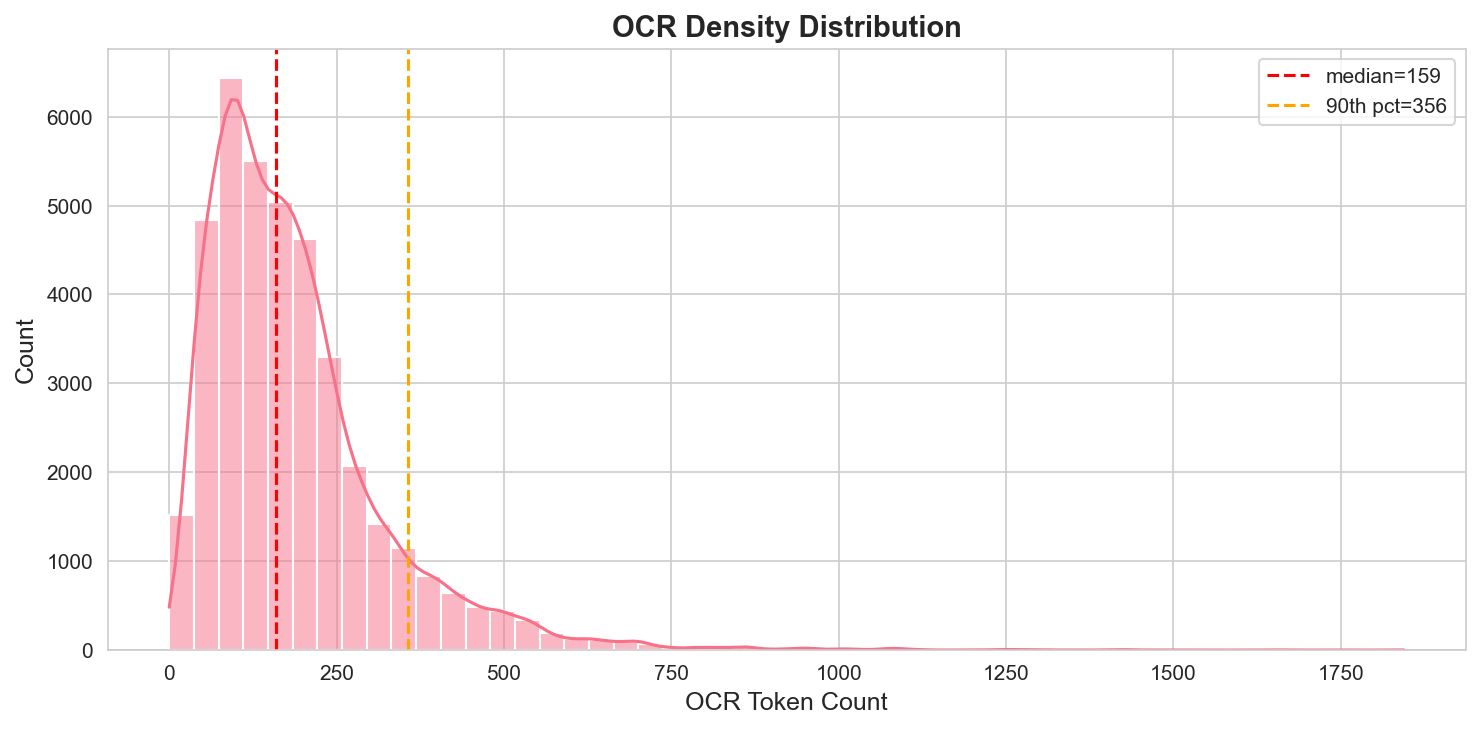

In [87]:
# Plot 1: OCR Density distribution (looking for right skew / long tail)
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(df['ocr_density'], bins=50, kde=True, ax=ax)
ax.axvline(df['ocr_density'].median(), color='red', linestyle='--', label=f"median={df['ocr_density'].median():.0f}")
ax.axvline(df['ocr_density'].quantile(0.9), color='orange', linestyle='--', label=f"90th pct={df['ocr_density'].quantile(0.9):.0f}")
ax.set_xlabel('OCR Token Count')
ax.set_title('OCR Density Distribution')
ax.legend()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'density_distribution.png', dpi=150)
plt.show()

Samples with spatial data: 32633


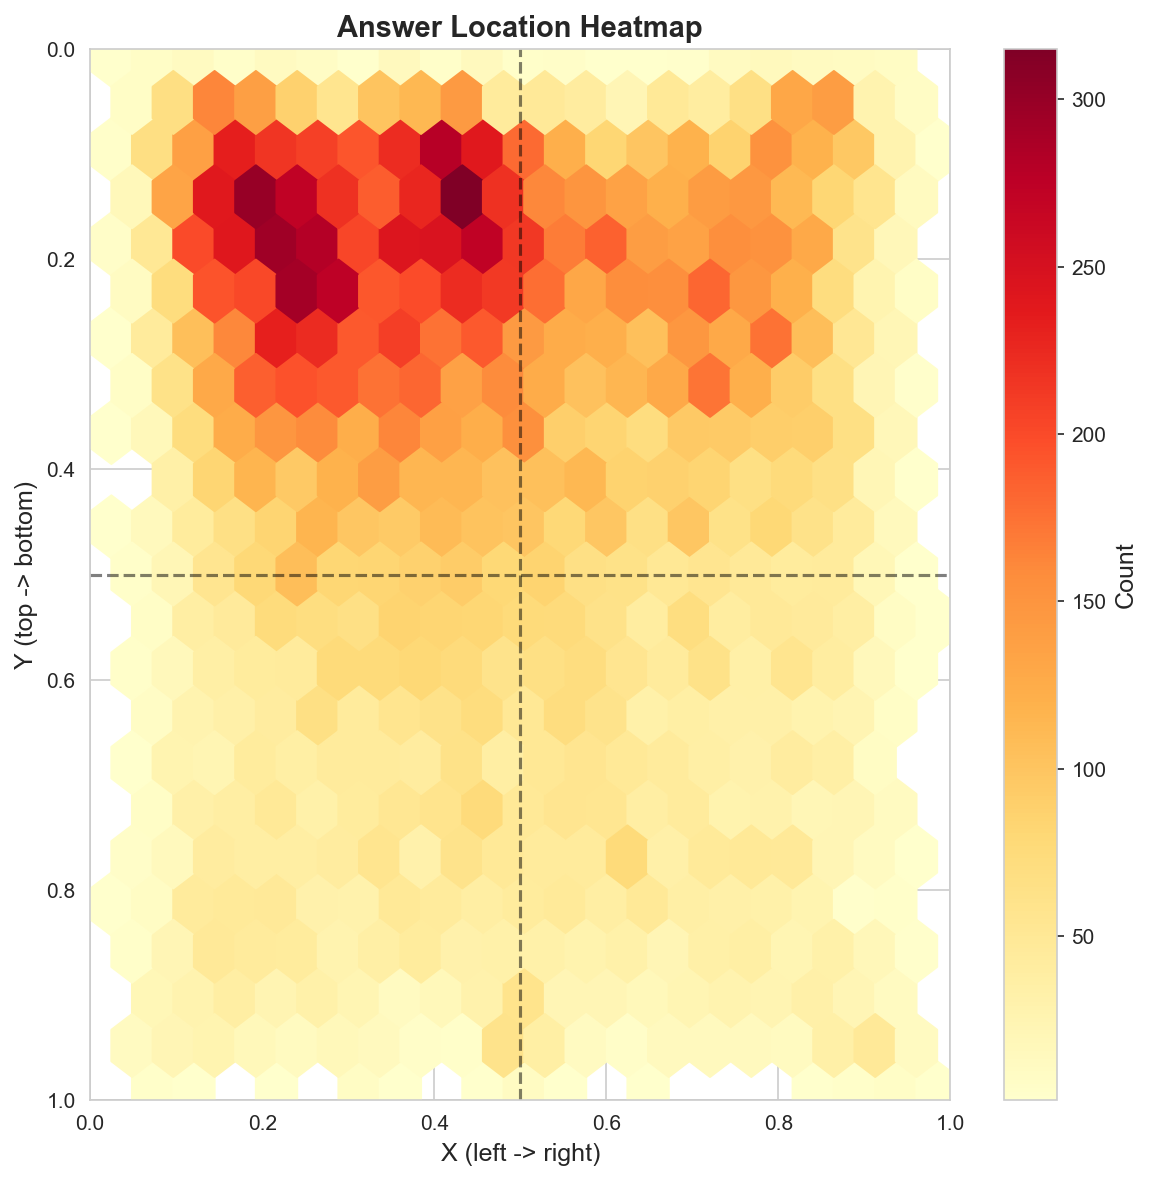

Top half: 76.1% | Left half: 59.0%


In [88]:
# Plot 2: Answer spatial distribution (hexbin)
spatial_df = df.dropna(subset=['answer_x', 'answer_y'])
print(f"Samples with spatial data: {len(spatial_df)}")

fig, ax = plt.subplots(figsize=(8, 8))
hb = ax.hexbin(spatial_df['answer_x'], spatial_df['answer_y'], gridsize=20, cmap='YlOrRd', mincnt=1)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.invert_yaxis()  # (0,0) = top-left
ax.set_xlabel('X (left -> right)')
ax.set_ylabel('Y (top -> bottom)')
ax.set_title('Answer Location Heatmap')
ax.axhline(0.5, color='black', linestyle='--', alpha=0.5)
ax.axvline(0.5, color='black', linestyle='--', alpha=0.5)
plt.colorbar(hb, ax=ax, label='Count')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'answer_spatial_heatmap.png', dpi=150)
plt.show()

# Quick quadrant check
top = (spatial_df['answer_y'] < 0.5).mean()
left = (spatial_df['answer_x'] < 0.5).mean()
print(f"Top half: {top*100:.1f}% | Left half: {left*100:.1f}%")

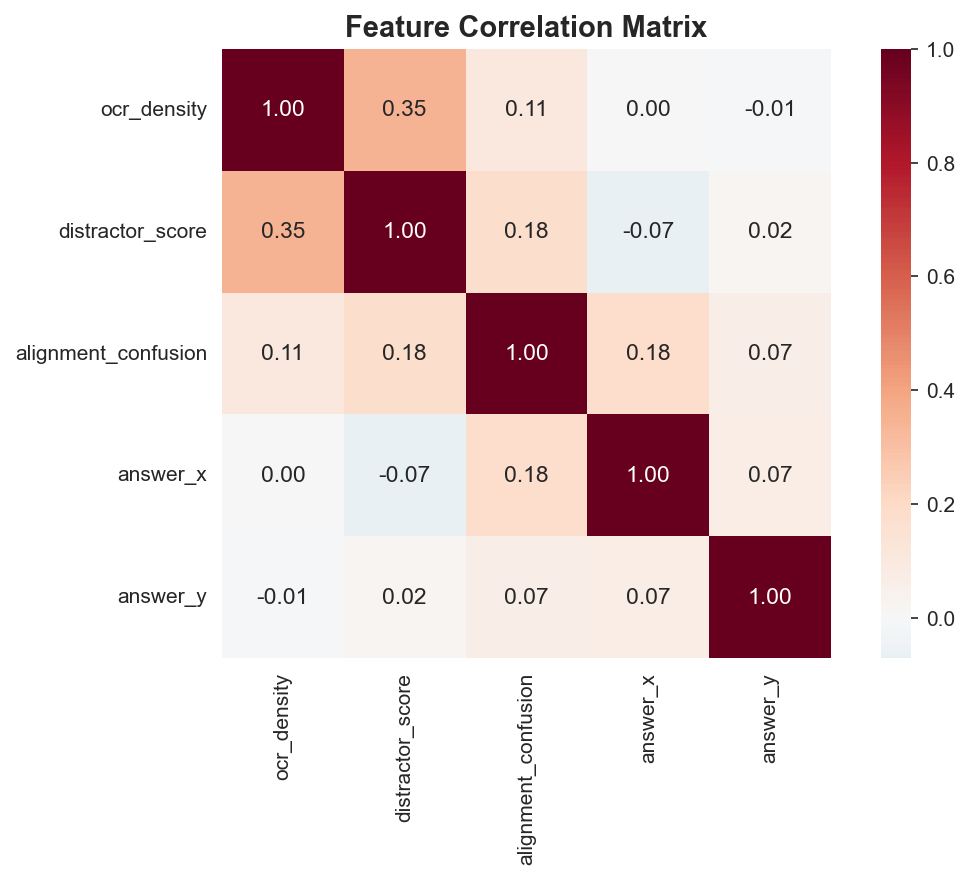


Key correlations with ocr_density:
  distractor_score: 0.349
  alignment_confusion: 0.112


In [89]:
# Plot 3: Correlation matrix - the key question
# Is distractor_score just a proxy for ocr_density, or independent?

features = ['ocr_density', 'distractor_score', 'alignment_confusion', 'answer_x', 'answer_y']
corr = df[features].corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=ax, square=True)
ax.set_title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'correlation_matrix.png', dpi=150)
plt.show()

# Key correlations
print(f"\nKey correlations with ocr_density:")
print(f"  distractor_score: {corr.loc['ocr_density', 'distractor_score']:.3f}")
print(f"  alignment_confusion: {corr.loc['ocr_density', 'alignment_confusion']:.3f}")

## 5. Results

In [90]:
# Check top "hardest" samples by distractor score
top_hard = df.nlargest(10, 'distractor_score')[['questionId', 'question', 'primary_answer', 'ocr_density', 'distractor_score', 'alignment_confusion']]
top_hard

,questionId,question,primary_answer,ocr_density,distractor_score,alignment_confusion
25557,39604,The book retails for how much?,$7.95,1653,38.0,0.0
36691,56132,What is the first side heading given?,leaf division,409,37.0,0.0
24800,38596,What waves Echocardiography use ?,ultra-high frequency sound waves,204,36.0,0.0
23403,36525,"What is the deisgnation of Arthur C. Guyton, M...",Professor and Chairman of the Department of Ph...,718,35.0,0.0
21905,34491,What type of hospitals is represented by 'N' ?,Experimental hospital,555,33.0,1.0
25153,39081,How much time of service 172 physicians have g...,"8,000 hours",1086,33.0,0.0
27514,42045,What is the address of Washington State Heart ...,"333 first avenue west, seattle",527,33.0,16.0
24867,38675,"As per the document how may ""Scientific Counci...",14,548,32.0,1.0
36454,55718,Which new category was created for women in Go...,Amodini,297,32.0,0.0
36798,56396,"In terms of volume, the company registered wha...",7.7%,539,32.0,3.0


In [91]:
# Interpretation
density_distractor_corr = df['ocr_density'].corr(df['distractor_score'])
density_alignment_corr = df['ocr_density'].corr(df['alignment_confusion'])

print("=" * 50)
print("FINDINGS")
print("=" * 50)

if abs(density_distractor_corr) < 0.5:
    print(f"Distractor score is weakly correlated with density (r={density_distractor_corr:.3f})")
    print("  -> Local crowding is a DISTINCT failure mode")
else:
    print(f"Distractor score correlates with density (r={density_distractor_corr:.3f})")

if abs(density_alignment_corr) < 0.5:
    print(f"Alignment confusion is weakly correlated with density (r={density_alignment_corr:.3f})")
    print("  -> Table structure is a DISTINCT failure mode")
else:
    print(f"Alignment confusion correlates with density (r={density_alignment_corr:.3f})")

FINDINGS
Distractor score is weakly correlated with density (r=0.349)
  -> Local crowding is a DISTINCT failure mode
Alignment confusion is weakly correlated with density (r=0.112)
  -> Table structure is a DISTINCT failure mode


In [92]:
# Save features to outputs folder
output_cols = ['questionId', 'question', 'image', 'primary_answer', 'question_types',
               'ocr_density', 'ocr_density_norm', 'answer_x', 'answer_y', 
               'distractor_score', 'alignment_confusion']

df_out = df[output_cols].copy()
df_out.to_pickle(OUTPUT_DIR / 'docvqa_features.pkl')
print(f"Saved {len(df_out)} samples to outputs/docvqa_features.pkl")

df_out.head()

Saved 39463 samples to outputs/docvqa_features.pkl


,questionId,question,image,primary_answer,question_types,ocr_density,ocr_density_norm,answer_x,answer_y,distractor_score,alignment_confusion
0,337,what is the date mentioned in this letter?,documents/xnbl0037_1.png,1/8/93,"[handwritten, form]",56,0.030369,NaN,NaN,NaN,NaN
1,338,what is the contact person name mentioned in l...,documents/xnbl0037_1.png,P. Carter,"[handwritten, form]",56,0.030369,0.276401,0.270988,1.0,1.0
2,339,Which corporation's letterhead is this?,documents/mxcj0037_1.png,Brown & Williamson Tobacco Corporation,[layout],323,0.175163,0.325031,0.125119,1.0,0.0
3,340,Who is in cc in this letter?,documents/mxcj0037_1.png,T.F. Riehl,"[form, layout]",323,0.175163,0.253736,0.235385,5.0,0.0
4,341,what is the subject of this letter?,documents/mxcj0037_1.png,Review of existing Brainstorming Ideas/483,"[form, layout]",323,0.175163,0.264633,0.322362,5.0,0.0


In [93]:
# Final folder structure
print("\nData folder structure:")
print(f"{DATA_DIR}/")
print(f"  train_v1.0_withQT.json    <- annotation")
print(f"  val_v1.0_withQT.json      <- annotation")
print(f"  test_v1.0.json            <- annotation")
print(f"  spdocvqa_images.tar.gz    <- archive")
print(f"  spdocvqa_ocr.tar.gz       <- archive")
print(f"  images/                   <- {len(list(IMAGES_DIR.rglob('*')))} extracted files")
print(f"  ocr/                      <- {len(list(OCR_DIR.rglob('*.json')))} extracted files")
print(f"  outputs/                  <- generated plots + features.pkl")


Data folder structure:
C:\Users\Aader\Desktop\Masters\S1 P3\Final Induvidual Assignment\Data/
  train_v1.0_withQT.json    <- annotation
  val_v1.0_withQT.json      <- annotation
  test_v1.0.json            <- annotation
  spdocvqa_images.tar.gz    <- archive
  spdocvqa_ocr.tar.gz       <- archive
  images/                   <- 12767 extracted files
  ocr/                      <- 12767 extracted files
  outputs/                  <- generated plots + features.pkl


In [ ]:
# Export to HTML
!jupyter nbconvert --to html "DocVQA_EDA.ipynb"